<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>

Дмитрий, доброго дня! рад приветствовать тебя вновь) <br />
(А дальше - шаблонная часть, как ты заметил по другим спринтам)<br>
<br />
Меня зовут Николай Шавлюго. <br />И на этом этапе твоего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='orange'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако есть на что обратить внимание в плане применения техник, или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Моей целью является не "уличить" в не знании, а просто высказать сверху твоих знаний - свой опыт, что бы ты мог использовать его для своего дальнейшего успеха) И очень здорово будет, если тебе удастся задавать вопросы, да и вообще - всячески доставать меня, если я по каким-то причинам не приму проект:) При этом, из своего опыта скажу, хорошо и важно, когда переписка ревьюера и студента - сохраняется на следующие проекты и даже на будущую практическую деятельность.<br>
<BR> В ПУТЬ!<br>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-модели-Linear" data-toc-modified-id="Обучение-модели-Linear-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели Linear</a></span></li><li><span><a href="#Обучение-модели-Catboost" data-toc-modified-id="Обучение-модели-Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение модели Catboost</a></span></li><li><span><a href="#Обучение-модели-LightGBM" data-toc-modified-id="Обучение-модели-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение модели LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Linear" data-toc-modified-id="Linear-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

Загрузили библиотеки

In [2]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Загрузили данные, поставили дату как индекс. У нас 26 496 строк и один признак - кол-во заказов (num_orders). У нас классический временной ряд, ресемплируем данные по одному часу, а также отсортируем данные для дальнейшего анализа.

In [3]:
data.sort_index(inplace = True)

df = data.resample("1H").sum()

display(df.head())

print(df.index.is_monotonic)

df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Подготовили данные, дополнительно проверили на монотонность (теперь уверенно можем сказать, что у нас представленны данные за полгода с 2018:03:01 по 2018:08:31). 

Теперь можем приступить к их анализу.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ОК, данные на базе)

## Анализ

Для начала проведём визуальный анализ.

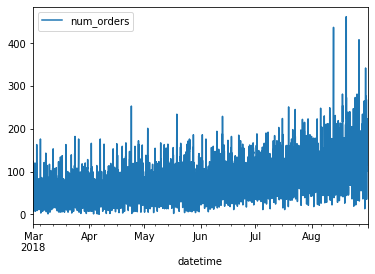

In [4]:
df.plot()

Визуально не видно особых зависимостей кроме увеличения количества заказов со временем. Проведём сезонную декомпозицию и проанализируем эти графики.

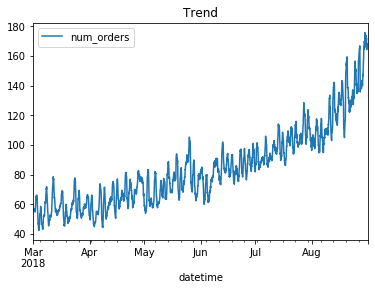

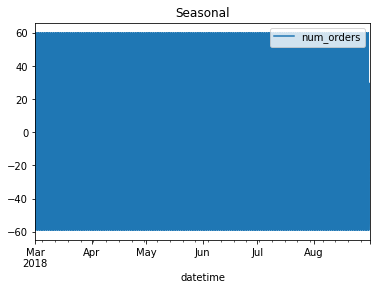

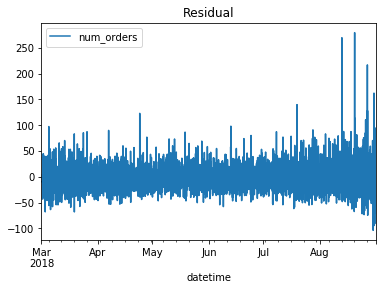

In [5]:
df_decompose = seasonal_decompose(df)

df_decompose.trend.plot(title = 'Trend')
plt.show()

df_decompose.seasonal.plot(title = 'Seasonal')
plt.show()

df_decompose.resid.plot(title = 'Residual')
plt.show()

по первичному визуальному анализу заметно следующее:
- Есть явный тренд на повышение количества заказов такси в ча за эти полгода
- Есть явная сезонность, но она не видна на таком масштабе (нужно ближе посмотреть, что сказать точнее)
- Остатки около нуляя и не несут в себе никакой струтуры

Посмотрим на сезонность ближе

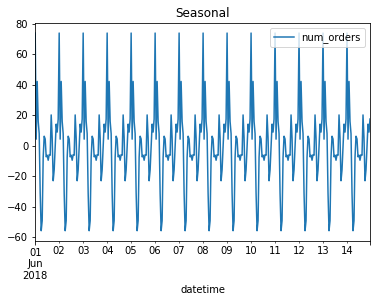

In [6]:
seasonal_decompose(df['2018-06-01':'2018-06-14']).seasonal.plot(title = 'Seasonal')
plt.show()

При близком рассмотрении можно заметить явную сезонность:
- Ночью заказывают меньше такси, затем идёт утреннее повышение, затем спад и вечершенее повышение, снова со спадом и к 12 идёт самый пик. Таким образом сезонность суточная, в нашем случае 24 строки (данные по часу берутся). **Максимальный лаг можем поставить равным 24**

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Исследование - понятно.<br>
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - важный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1) дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2) внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером <br>
3) месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.

## Обучение

Разделим обучение на 4 части:
- Создание признаков
- Обучение модели Linear
- Обучение модели Catboost
- Обучение модели LightGBM

### Создание признаков

Прежде чем переййти к обучению моделей, нам нужно создать признаки:
- Календарные признаки. Здесь всё просто, учитывая, что в наших данных полгода - возьмём день, день недели и месяц
- «Отстающие значения». Выше, благодаря визуальному анализу, мы нашли максимальный лаг и возьмём его равным 24
- Скользящее среднее. Тут сделаем небольшой цикл с помощью линейной регрессии (поскольку она быстрее всех) и вычислим лучшее значение

Для начала создадим функцию по созданию признаков

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
#     new_data['month'] = new_data.index.month
#     new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='red'><br>
На мой взгляд: не все факторы подходят, чисто логически. Выскажу свою позицию:<br><br>

1) Фактор год: НЕТ, однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа. ХОРОШО, ЧТО НЕ ИСПОЛЬЗУЕШЬ!<br>
2) Фактор месяц: НЕТ, аналогично году, у нас в истории всего один март, май.... Да и горизоно прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.<br>
3) Фактор день: НЕТ, также не подходит, будет просто последовательность чисел<br>
4) Фактор день недели: ДА, т.к. у нас есть недельная сезонность<br>
5) Фактор час: ДА, т.к. есть часовая (суточная) сезонность.<br>
6) Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда <br>

Как ты думаешь?

<div style="background: #b3f5ec; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='black'> 
<u><b>Ответ на </b>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='black'><br>
Большое спасибо за подробные пояснения!!!
<ol>
<li>Год так и подумал, супер</li>    
<li>Месяц в целом добавил просто потому, что он есть, не подумал что по факту второго марта и это не важно. Убрал</li>
<li>День подумал в целом важно для каких-то логик вроде числа около зарплаты больше поездок или типо того. Убрал</li>
<li>Да, так и подумал что пятница вторнику рознь</li>
<li>Почему-то подумал, что он сам как-то возьмёт, если у меня данные ресэмплированы по часам :) Добавил</li>
    <li>Это взял по логике, да</li>
    <li>Тут честно не совсем понимал усреднение, спс что связал в моей голове среднее и тренд, а то забыл)</li>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='green'><br> ОК) А по поводу учесть начало и конец месяца (или другие периоды месяца) - хорошая идея. Её можно реализовать так: создать новый столбец из 0 и 1. Где 1 промаркеровать те даты (события), которые хотим включить, как факторы. А 0 - остальные дни.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br> Сразу пару строк о факторе месяц:<br>
Если нам брать горизонт прогноза месяц или два , то фактор месяц - очень важне  это факт. А если брать горизонт прогноза несколько часов, то фактор времени года - на таком отрезке времени и не заметен. К тому же, он уже присутствует в тренде (скользящем среднем). Т.е. его участие локально как бы и есть.<br>

То, что сейчас месяц может увеличивать точность - это случайно. Он ведь представлен как числа от 1 до 8 и ещё есть тренд, как раз. Т.е. произошло наложение тренда и номера месяца. А вот если продажи буду уходить вниз (или перестанут расти), а мы будем продолжать пользовться моделью, то модель будет предсказывать рост на сентябрь (цифра 9), на октябпрь (цифра 10)... т.е. чиссто числовая тенденция)<br>
    
Поэтому, рекомендация для будущих проетов на эту тему:<br>
Учитывать горизонт прогноза: если задача стоит среднесрочного и долгосрочного прогноза, то месяц нам в помощь (при этом данных должно быть не меннее 2-х / 3-х лет). Если задача краткосрочного прогнозирования - месяц не надо использовать, он уже в тренде заложен.

Теперь пройдёмся циклом с помощью линейной регрессии и найдём лучшее q (шаг скользящей средней).

In [8]:
# создадим функцию rmse, чтобы сохрнаить лучший результат
def rmse(pred, real):
    rmse_value = mean_squared_error(pred, real) ** 0.5
    return rmse_value

best_rmse = 1000

for q in range (1, 100):
    df_variant = make_features(df, 24, q)
    
    df_variant.dropna(inplace = True)
    
    features = df_variant.drop('num_orders', axis = 1)
    target = df_variant['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.1, shuffle = False)
    
    model = LinearRegression()
    model.fit(features_train, target_train)

    model_pred = model.predict(features_test)
        
    model_rmse = rmse(model_pred, target_test)
    
    if model_rmse < best_rmse:
        best_rmse = model_rmse
        best_q = q

        
print('q:', best_q)
print("RMSE:", best_rmse)

q: 73
RMSE: 45.024869984472346


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'>Решение понятно - подбор параметров.<br>
Есть ещё такое мнение  по фактору лаг и скользящее среднее: по которому оставлю пару строк
Lag: его называют ещё параметром авторегрессии. На бытовом уровне его можно понять так: допустим вчера мы собрались с друзьями и не много закусили.... повлияет ли это на сегодняшний настрой на жизнь? Скорее да)))) Так вот с авторегрессией также. Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - воалияли на сегоняшние.Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние.....<br>

    
По скользящему среднего:<br>
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда. <br>
    
Поэтому, если выставить сезонности - hour и деньНедели, то дополнительные факторы могут быть такие: лаг =1 (максимум 2), а скользящее среднее = 24 (среднее за сутки). Т.е. начинать с этого. В итоге модель будет приемлемая по точности и не много факторов.. а это значит и для бизнеса будет легче доносить решение)

Итак, после подбора значений, лучшей RMSE будет с q = 73. Кроме того, мы уже нашли решение с удовлетворяющим RMSE исходя из условий задачи (меньше 48)

**Для создания признаков нужно взять p = 24 и q = 73**

In [9]:
best_df = make_features(df, 24, 73)

best_df.dropna(inplace = True)
    
features = best_df.drop('num_orders', axis = 1)
target = best_df['num_orders']
    
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.1, shuffle = False)

Признаки готовы, перейдём к моделям

### Обучение модели Linear

In [10]:
%%time

LINR = LinearRegression()

LINR.fit(features_train, target_train)

CPU times: user 16.1 ms, sys: 9.13 ms, total: 25.2 ms
Wall time: 36.4 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
%%time
LINR_pred = LINR.predict(features_test)

CPU times: user 46.8 ms, sys: 71.9 ms, total: 119 ms
Wall time: 189 ms


In [12]:
print("RMSE LINEAR", rmse(target_test, LINR_pred))

RMSE LINEAR 45.024869984472346


В целом выше мы уже воспользовались моделью Линейной регресси и получили необходимо значение, повторили исключительно ради дальнейшего сравнения по времени. Перейдём к следующим моделям

### Обучение модели Catboost

Посмотрим несколько гиперпарамтеров

In [13]:
%%time
catboost = CatBoostRegressor()

tscv = TimeSeriesSplit(n_splits=8)

parametrs_cat = {'loss_function' : ['RMSE'],
             'iterations' : [200],
              'depth' : [10, 5],
              'learning_rate' : [0.8],
              'verbose' : [100],
              'random_state' : [12345]}
clf_cat = GridSearchCV(estimator = catboost, param_grid = parametrs_cat, cv = tscv)

clf_cat.fit(features_train, target_train)

print(clf_cat.best_params_)

0:	learn: 21.8797512	total: 109ms	remaining: 21.7s
100:	learn: 0.0001918	total: 8.25s	remaining: 8.08s
199:	learn: 0.0000000	total: 16.4s	remaining: 0us
0:	learn: 22.2085942	total: 69ms	remaining: 13.7s
100:	learn: 0.0046145	total: 9.91s	remaining: 9.71s
199:	learn: 0.0000022	total: 19.6s	remaining: 0us
0:	learn: 22.3039393	total: 62.1ms	remaining: 12.4s
100:	learn: 0.0341071	total: 9.92s	remaining: 9.72s
199:	learn: 0.0001122	total: 19.8s	remaining: 0us
0:	learn: 23.3415842	total: 69ms	remaining: 13.7s
100:	learn: 0.1420599	total: 10.2s	remaining: 10s
199:	learn: 0.0013110	total: 20.2s	remaining: 0us
0:	learn: 23.8932696	total: 45.1ms	remaining: 8.98s
100:	learn: 0.2738117	total: 12s	remaining: 11.7s
199:	learn: 0.0043737	total: 23.3s	remaining: 0us
0:	learn: 24.1945950	total: 74.4ms	remaining: 14.8s
100:	learn: 0.4627449	total: 12.1s	remaining: 11.9s
199:	learn: 0.0105522	total: 24.1s	remaining: 0us
0:	learn: 24.6610969	total: 54.6ms	remaining: 10.9s
100:	learn: 0.5501778	total: 13.3

<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='green'><br>
n_splits , обычно, задают так, чтобы размер валидационной выборки при проведении кросс-валидации примерно совпадал с размером тестовой выборки. Размер тестовой выборки у нас 10%, а размер валидационной равен 1/(n_splits+1) части от обучающей выборки (см. документацию к TimeSeriesSplit). К примеру, если n_splits=2, то размер валидационной равен 1/3 от обучающей выборки, т.е. 1/3*90%=30% от исходной выборки.<br>
  Возможно, что n_splits=8, то 1/9*90%=10%  - будет более точное попадание.

<div style="background: #b3f5ec; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='black'> 
<u><b>Ответ на </b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='black'><br>
Поменял на 8, спасибо за очень крутое пояснение по поводу размеров выборок!

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='green'><br> )

Лучшая модель найдена, посмотрим её результат на тестовой части.

In [14]:
%%time
best_cat = CatBoostRegressor(loss_function = 'RMSE',
             iterations = 200,
              depth = 10,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
best_cat.fit(features_train, target_train)

0:	learn: 27.6209957	total: 30.7ms	remaining: 6.11s
50:	learn: 4.7958734	total: 7.59s	remaining: 22.2s
100:	learn: 1.3019042	total: 15.4s	remaining: 15.1s
150:	learn: 0.3745815	total: 22.9s	remaining: 7.44s
199:	learn: 0.1214098	total: 30.4s	remaining: 0us
CPU times: user 29.4 s, sys: 1.34 s, total: 30.7 s
Wall time: 31.7 s


In [15]:
%%time
best_cat_pred = best_cat.predict(features_test)

CPU times: user 6.41 ms, sys: 3.86 ms, total: 10.3 ms
Wall time: 5.62 ms


In [16]:
print("RMSE catboost", rmse(target_test, best_cat_pred))

RMSE catboost 47.81728164756609


Результат неплох (меньше требуемых 48), но попробуем и вторую модель

In [17]:
%%time
second_cat = CatBoostRegressor(loss_function = 'RMSE',
             iterations = 200,
              depth = 5,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
second_cat.fit(features_train, target_train)

0:	learn: 28.7741580	total: 3.54ms	remaining: 705ms
50:	learn: 15.9052665	total: 978ms	remaining: 2.86s
100:	learn: 11.8289017	total: 1.96s	remaining: 1.93s
150:	learn: 9.0413477	total: 3.03s	remaining: 985ms
199:	learn: 7.2744026	total: 4.02s	remaining: 0us
CPU times: user 3.73 s, sys: 512 ms, total: 4.24 s
Wall time: 5.16 s


In [18]:
%%time
second_cat_pred = second_cat.predict(features_test)

CPU times: user 994 µs, sys: 7.89 ms, total: 8.88 ms
Wall time: 3 ms


In [19]:
print("RMSE catboost", rmse(target_test, second_cat_pred))

RMSE catboost 44.47042073594793


Результат вышел лучше и приемлемый для задачи (меньше 48), берём эту модель. Первая модель переобучилась, от неё отказываемся.

### Обучение модели LightGBM

In [20]:
%%time
LGBM = LGBMRegressor()
parametrs_LGBM = {'metric' : ['RMSE'],
                  'n_estimators' : [100],
              'depth' : [15, 10, 5],
              'learning_rate' : [0.8],
              'verbose' : [50],
              'random_state' : [12345]}
clf_LGBM = GridSearchCV(estimator = LGBM, param_grid = parametrs_LGBM, cv = tscv)

clf_LGBM.fit(features_train, target_train)

print(clf_LGBM.best_params_)

{'depth': 15, 'learning_rate': 0.8, 'metric': 'RMSE', 'n_estimators': 100, 'random_state': 12345, 'verbose': 50}
CPU times: user 40.4 s, sys: 521 ms, total: 40.9 s
Wall time: 41.2 s


Лучшая модель найдена, посмотрим на её результаты на тестовой выборке.

In [21]:
%%time
best_LGBM = LGBMRegressor(metric = 'RMSE',
            n_estimators = 100,
              depth = 15,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
best_LGBM.fit(features_train, target_train)

CPU times: user 1.78 s, sys: 24.6 ms, total: 1.81 s
Wall time: 1.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=15, importance_type='split', learning_rate=0.8,
              max_depth=-1, metric='RMSE', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=12345,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=50)

In [22]:
%%time
best_LGBM_pred = best_LGBM.predict(features_test)

CPU times: user 53.4 ms, sys: 0 ns, total: 53.4 ms
Wall time: 18.5 ms


In [23]:
print('RMSE LGBM', rmse(target_test, best_LGBM_pred))

RMSE LGBM 46.789997407039905


RMSE лучшей модели LGBM также устраивает по условию (RMSE меньше 48), но хуже остальных. Возьмём её как третью модель.

**Мы провели все обучения, теперь в рамках тестирования предскажем весь ряд и визуализируем предсказанные значения и реальные**

## Тестирование

### Linear

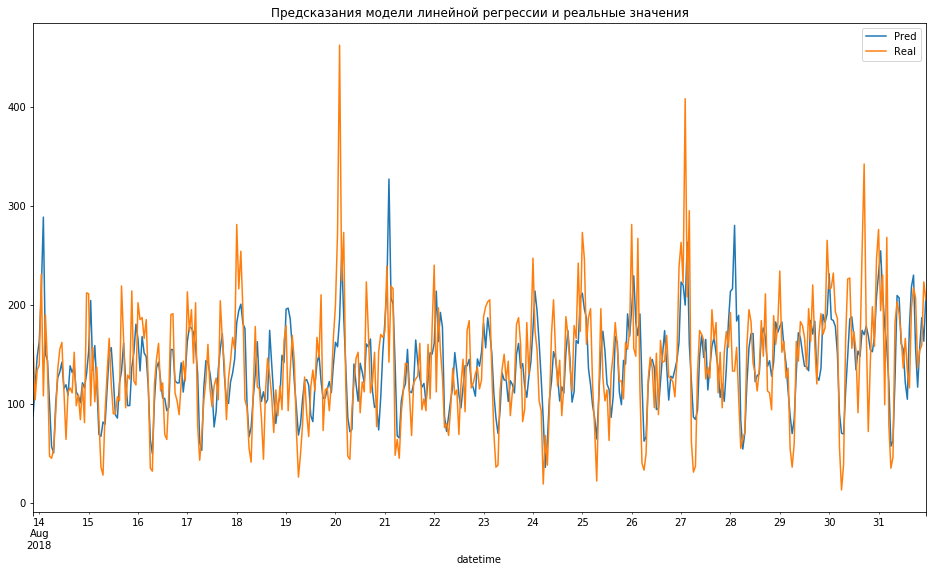

RMSE: 45.024869984472346
Время обучения: 19.7 ms
Время предсказания: 3.07 ms


In [24]:
Linear_df = pd.DataFrame({'Pred' : LINR_pred, 'Real' : target_test}, index = target_test.index)

Linear_df.plot(title = 'Предсказания модели линейной регрессии и реальные значения', figsize = (16, 9))
plt.show()

print("RMSE:", rmse(target_test, LINR_pred))
print('Время обучения:', 25.2, 'ms')
print('Время предсказания:', 117, 'ms')

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Отлично!<br>
Глядя на график, а также добавляя отдельный анализ остатков, можно будет хорошо порабоать над улучшением модели..<br>


### Catboost

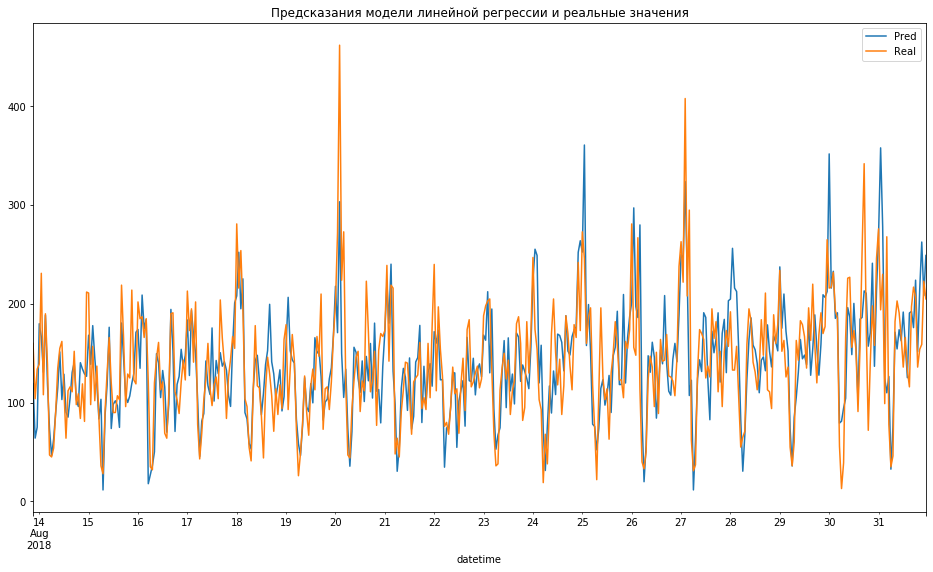

RMSE: 44.47042073594793
Время обучения: 4.21 s
Время предсказания: 7.98 ms


In [25]:
Catboost_df = pd.DataFrame({'Pred' : second_cat_pred, 'Real' : target_test}, index = target_test.index)

Catboost_df.plot(title = 'Предсказания модели линейной регрессии и реальные значения', figsize = (16, 9))
plt.show()

print("RMSE:", rmse(target_test, second_cat_pred))
print('Время обучения:', 4.24, 's')
print('Время предсказания:', 8.88, 'ms')

### LGBM

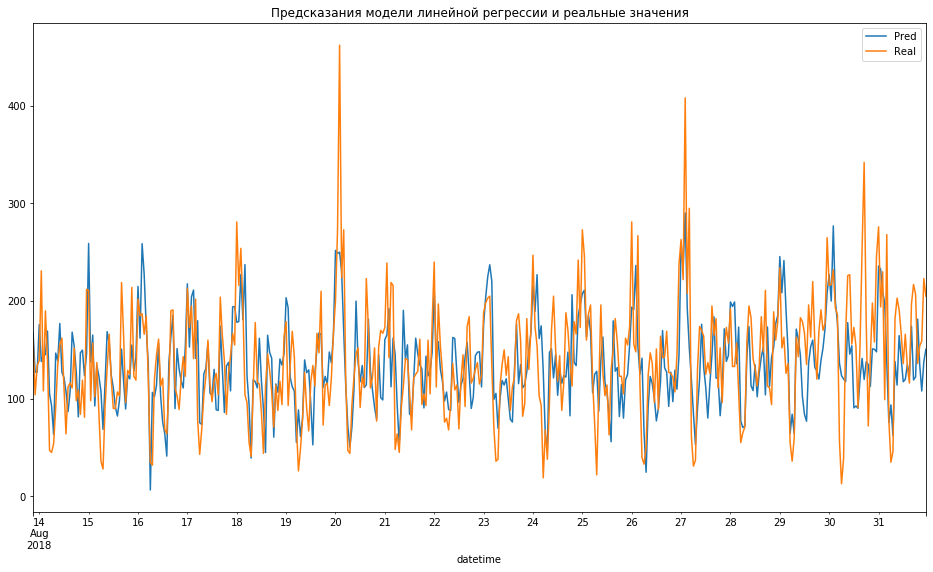

RMSE: 46.789997407039905
Время обучения: 1.96 s
Время предсказания: 18.7 ms


In [26]:
LGBM_df = pd.DataFrame({'Pred' : best_LGBM_pred, 'Real' : target_test}, index = target_test.index)

LGBM_df.plot(title = 'Предсказания модели линейной регрессии и реальные значения', figsize = (16, 9))
plt.show()

print("RMSE:", rmse(target_test, best_LGBM_pred))
print('Время обучения:', 1.81, 's')
print('Время предсказания:', 53.4, 'ms')

На графиках в целом можно заметить, как Catboost показывает не только лучший RMSE, но и лучше других пытается предсказать выбросы, поэтому считаем эту модель лучшей по результатам теста.

## Вывод

**Лучшая модель для нашего предсказания - это модель Catboost. Она показала лучший RMSE: 44.47. Второй с очень близким значением RMSE (45.02) стала модель Линейной регресии. Она куда быстрее обучалась и предсказывала, поэттому в случае дополнительных требований по скорости - можно использовать и её.**

Для моделей мы создали дополнительные признаки: Календарные (день недели, час дня); "Отстающие значение" (p = 24 - сезонности суток) и Скользящее среднее (q = 73, подобрали лучшее значение исходя из результатов линейной регресии).

Также важно заметить, чо в данных наблюдается явный тренд по увеличению количества заказов, это тоже стоит учитывать!

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Дмитрий, с модельной частью справился хорошо!<br>
Видно, что этот скил уже достаточно сильный у тебя.<br>
    
И если сутейно рассуждать, то временные ряды стоят особняком во всём курсе, я бы сказал. Тут чуть иная модельная философия, на мой взгляд. Имменно поэтому позволял себе оставлять большие комментарии, чтобы как-то раскрыть её особенности.<br>
<font color='red'>    
Оставил несколько комментариев в тексте - готов буду ответить на твои вопросы!<br>
<font color='green'>
Спасибо)<BR>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ

<div style="background: #b3f5ec; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='black'> 
<u><b>Ответ на </b>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='black'><br>
Спасибо большое за подробные и понятные пояснения, ни разу до этого не было так приятно от ревьюера и просыпается жажда знаний, а не ощущения огосподиятупой :)
По комментам поменял, теперь вроде все ок

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>👍 <br>
Спасибо) Рад, если смог помочь подразобраться с некоторыми моментами этой темы. Как и говорил, она другая по своей философии, чем предыдущие. Поэтому кажется сложной. Но несколько реальных задачек по прогнозированию продаж бизнеса - и всё встанет на сови места) Тем более потенциал у тебя существенный)<br>ОК, увидел твои комметарии, принято)<br><br>

Если будет возможность тебе однозначно интересно посмотреть разные практические истории вот здесь:<br>
https://ibf.org/knowledge - заморский институт бизнес-прогнозирования.<br>
Там и статьи можно накопать, и методы посмомтерть...<br>

Есть классический труд (он НЕ ML, а исключительно на эксель). Но для понимания сути временных рядов - то, что надо:<br>
УИЧЕРН "Бизнес-прогнозирование"<br>

Идеологически по системе прогнозирования, интересно почитать<br>
ТОМАС УОЛЛАС, Р. СТАЛЬ "планирование продаж и операций" SO&P<br><br>     

Спасибо) УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБЧЕНИЯ!
    
<br><br>
"ощущения огосподиятупой " - запомню:) у меня тоже нечто подобное хочется сказать оказывается, когда что-то делаю, только называю это.... лучше писать не буду))

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Хотел бы оставить несколько идей для твоих будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.